In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

## Camera Calibration

In [40]:
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points like (0,0,0),(1,0,0),(2,0,0),...(nx-1,ny-1,0)
nx = 9
ny = 6
patternSize = (nx, ny)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

total images  20
corners found  34
corners not found  3


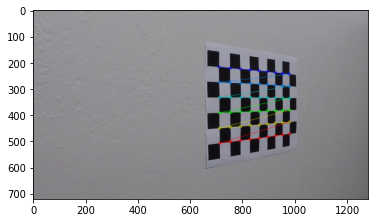

In [42]:
calibFileNames = glob.glob('camera_cal/calibration*.jpg')
cornersNotFoundCount = 0
lastImgWithCorners = None
for fname in calibFileNames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    patternWasFound, corners = cv2.findChessboardCorners(gray, patternSize, None)
    if patternWasFound == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, patternSize, corners, patternWasFound)
        lastImgWithCorners = img
        # save images locally
        # imgToSave = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        # cv2.imwrite('output_images/' + fname.split('/')[1], imgToSave)
    else:
        cornersNotFoundCount += 1

plt.imshow(lastImgWithCorners)
print("total images ", len(calibFileNames))
print("corners found ", len(objpoints))
print("corners not found ", cornersNotFoundCount)